### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
import re
import string
from spellchecker import SpellChecker
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

In [2]:
#Install pyspellchecker module, if does not exists, 
#this module is a Pure Python Spell Checking based on Peter Norvig’s blog post on setting up a simple spell checking algorithm.

#!pip install pyspellchecker

In [25]:
#install Spacy library for advanced natural language processing, this will be used to perform lemmatization
#!pip install spacy
!pip -m spacy download en_core_web_sm


Usage:   
  pip <command> [options]

no such option: -m


### Data Load

In [4]:
path = r'..\Data\01_Clean_Review_Data.json'
Review_DF = pd.read_json(path)

In [5]:
Review_DF.head()

,User_ID,Product_ID,User_Name,Rating_Helpfulness,Text_Review,Ratings,Review_Summary,Review_Date
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400000
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600000
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800000
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600000
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600000


In [6]:
Review_DF['Review_Date'] = pd.to_datetime(Review_DF['Review_Date'])

In [7]:
Review_DF['Text_Review']

0         They look good and stick good! I just don't li...
1         These stickers work like the review says they ...
2         These are awesome and make my phone look so st...
3         Item arrived in great time and was in perfect ...
4         awesome! stays on, and looks great. can be use...
                                ...                        
194434    Works great just like my original one. I reall...
194435    Great product. Great packaging. High quality a...
194436    This is a great cable, just as good as the mor...
194437    I really like it becasue it works well with my...
194438    product as described, I have wasted a lot of m...
Name: Text_Review, Length: 194439, dtype: object

## Preprocessing - Text Normalization

Text Normalization(Text wrangling or cleansing) is a process of transforming text into a form that can be used by NLP and analytics systems and applications as input. It can consist of various steps like:-
* Tokenization 
* Cleaning text 
* Removing Special Characters
* Correcting spelling 
* Removing stopwords, punctuations or unwanted tokens
* Case conversion 
* Stemming
* Lemmatization.

#### 1: Tokenization

Tokenization is the process of transforming a string or document into smaller chunks, which we call tokens. This is usually one step in the process of preparing a text for natural language processing. 

**Sentence Tokenization** is a process of converting text corpus into sentences which is the first level of tokens. This is also called Sentence Segmentation because we try to segment the text into meaningful sentences.

**Word Tokenization** is a process of splitting sentences into words.

In [8]:
#Defined Tokenization fuction
# The following function will take any sentence and convert it into word tokens
# Then strip leading and trailing spaces
def Tokenize_Text(text):
    word_tokens = word_tokenize(text)
    tokens = [token.strip() for token in word_tokens]
    return tokens

#### 2: Removing Special Characters
One important task in text normalization involves removing unnecessary and special characters. These may be special symbols or punctuations that occurs in sentences. <br>
Special Characters and symbols are usually non-alphanumeric characters or even occaionally numeric characters(depending on the problem) which adds extra noise to unstructured text data and does not add much significance while analyzing text and untilzing it for feature extraction. [Link](https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72)

In [9]:
#Defining function to remove special characters keeping only apha characters
def Remove_Special_Characters(text):
    text = text.strip()
    pattern = '[^a-zA-z]'
    filtered_text = re.sub(pattern, ' ', text) #Replace matches with spaces
    return filtered_text

#### 3: Removing Stop Words
Stopwords are the words that has little or no significance especially when consturcting meaningful features from text. They are removed from the text so that we are left with words having maximum significance. <br>
They are usually words that have maximum frequency if you aggregate any corpus of text based on singular tokens. <br>
Ex:- a, the, of and so on.

In [10]:
#If nltk stopwords does not exist, uncomment and run
#nltk.download('stopwords') 

In [11]:
#In Python, searching through set is much faster than list.
stopword_set = set(stopwords.words("english"))

#Defining a function to remove stopwords
def Remove_Stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stopword_set]
    return filtered_tokens

#### 4: Correcting Words
Incorrect spellings are very normal and also one of the main challeges faced in Text Normalization. The definition of incorrect here covers words that have spelling mistakes as well as words with several letters repeated that do not contribute much to its overall significance.
##### 4.1 Correcting Repeating Characters

In [12]:
#If got LookupError(nltk stopwords does not exist), uncomment and run
#nltk.download('wordnet') 

In [13]:
from nltk.corpus import wordnet

# Define function to remove repeated characters
def Remove_Repeated_Characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if(wordnet.synsets(old_word)):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word) # substitutes a wrong spelling like "Hellooooo" to "Hello"
        return replace(new_word) if new_word != old_word else new_word

    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

##### 4.2 Correcting Spellings 
[How to Write Spelling Corrector](https://norvig.com/spell-correct.html)

In [14]:
#Generate a word vocabulary, which will be used as a reference to check the spelling using a file containing severl books from 
#Gutenberg corpus and also list of most frequent words from wiktionary and British National Corpus. You can download it from
# http://norvig.com/big.txt

def tokens(text):
    return re.findall('[a-z]+', text.lower())

path = '../Raw_Data/big.txt'

with open(path) as file:
    doc = file.read()

words = tokens(doc)
word_counts = Counter(words)

In [15]:
# Define functions that compute sets of words that are one and two edits away from input word.
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [16]:
# Define function that returns a subset of words from our candidate set of words obtained from 
# the edit functions, based on whether they occur in our vocabulary dictionary word_counts.
# This gives us a list of valid words from our set of candidate words.
def known(words): 
    "The subset of `words` that appear in the dictionary of WORD_COUNTS."
    return set(w for w in words if w in word_counts)

In [31]:
# Define function to correct words
def Correct_Words(words):
    # Get the best correct spellings for the input words
    def candidates(word): 
        # Generate possible spelling corrections for word.
        # Priority is for edit distance 0, then 1, then 2, else defaults to the input word itself.
        candidates = known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
        return candidates
    
    corrected_words = [max(candidates(word), key=word_counts.get) for word in words]
    return corrected_words

#### 5: Lemmatization 
[Lemmatization vs Stemming](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/)

It is process of removing affixes from the word to get that into its base form. The base form of the word is also called as the root word and will always be present in the dictionay. 

In [26]:
#You may get OSError:[E050] Can't find model 'en_core_web_sm'
#Open anaconda prompt and run "python -m spacy download en_core_web_sm"
nlp = spacy.load("en_core_web_sm")

In [33]:
#Defining function for lemmatization
def Lemmatize_Tokens(tokens):
    doc = ' '.join(tokens)
    Lemmatized_tokens = [token.lemma_ for token in nlp(doc)]
    return Lemmatized_tokens

#### 7: Text Normalization

In [28]:
def Normalize_Text_Corpus(corpus):
    normalized_corpus = []
    for text in corpus:
        text = text.lower()
        text = Remove_Special_Characters(text)
        tokens = Tokenize_Text(text)
        tokens = Remove_Stopwords(tokens)
        tokens = Remove_Repeated_Characters(tokens)
        tokens = Correct_Words(tokens)
        tokens = Lemmatize_Tokens(tokens)
        text = ' '.join(tokens)
        normalized_corpus.append(text)
    return normalized_corpus

In [ ]:
Normalized_Reviews = Normalize_Text_Corpus(Review_DF.Text_Review)

In [ ]:
Review_DF['Normalized_Reviews'] = Normalized_Reviews

-------------------------------------------------------------------------------------------------------------------------------
## Feature Engineering 
It is process of creating features for machine learning models from Raw Text Data.[Link](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d#:~:text=NLP%20is%20often%20applied%20for,model%20from%20raw%20text%20data.)
* Bag of Words

#### 1: Bag of Words Model
Bag of words is a very simple and basic method to finding topics in a text. For bag of words you need to tokenize the sentences and the count the occurence of each word. <br> The more frequent a word or token is, the more central or important it might be to the text. Bag of words can be a great way to determine the significant words in a text, based on the number of times they are used. <br> Documents are describe by the word occurence and while completely ignoring the relative position information of the words in the document.

**Vectorization** It is a general process of converting text documents into numerical feature vectors. 

**Corpus:** Set of large and structured set of text that are used to do statistical analysis and hypothesis testing, checking occurrences or validating linguistic rules within a specific language territory.

In [ ]:
#Defining the fuction to generate bag of words, which take text corpus as input.
#Count Vectorizer, implements both tokenization and occurence counting in a single class
def Bag_of_words(corpus):
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transfor(corpus)
    return vertorizer, features

#### 2: TF-IDF Model
In TF-IDF model, TF stands for Token(Term) Frequency and IDF stands for Inverse document frequency.
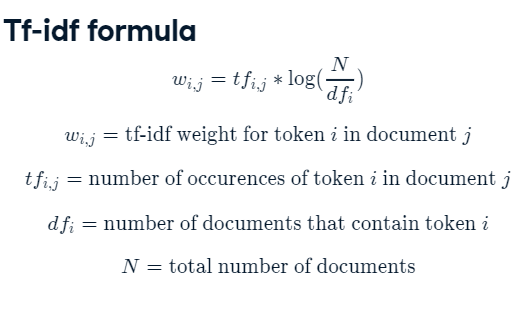

In [ ]:
#Defining the function to compute tfidf based feature vectors for documents.
def tfidf(corpus):
    vectorizer = TfidfVectorizer()
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features